#  Application Lab #1 ATOC5860 Objective Analysis - bootstrapping
##### Originally coded by Prof. Kay (CU) with input from Vineel Yettella (CU ATOC Ph.D. 2018)
##### last updated January 16, 2024

### LEARNING GOALS:
1) Use an ipython notebook to read in csv file, print variables, calculate basic statistics, do a bootstrap, make histogram plot
2) Hypothesis testing and statistical significance testing using bootstrapping
3) Contrast results obtained using bootstrapping with results obtained using a t-test

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze the relationship between Tropical Pacific Sea Surface Temperature (SST) anomalies and Colorado snowpack. Specifically, you will test the hypothesis that December Pacific SST anomalies driven by the El Nino Southern Oscillation affect the total wintertime snow accumulation at a mountain pass in Colorado.  When SSTs in the central Pacific are anomalously warm/cold, jet and precipitation locations can change. But do these atmospheric teleconnections affect total Colorado snow accumulation in the following winter? This notebook will guide you through an analysis to investigate the connections between December Nino3.4 SST anomalies (in units of °C) and the following April 1 Berthoud Pass, Colorado Snow Water Equivalence (in units of inches). Note that SWE is a measure of the amount of water contained in the snowpack.  To convert to snow depth, you multiply by ~5 (the exact value depends on the snow density).

The data have already been munged into a file called 'snow_enso_data_1936-2022.csv'. The Berthoud Pass SWE data are from: https://www.nrcs.usda.gov/wps/portal/wcc/home/snowClimateMonitoring/ and
https://wcc.sc.egov.usda.gov/nwcc/rgrpt?report=snowmonth_hist&state=CO. The Nino3.4 data are from: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/

### First, let's load packages, read in data, look at your data

In [1]:
%matplotlib inline  
# this enables plotting within notebook

import matplotlib   # library for plotting
import matplotlib.pyplot as plt #  later you will type plt.$COMMAND
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
### Read in the data
filename='snow_enso_data_1936-2022.csv'
data=pd.read_csv(filename,sep=',')
data.head()

,Year,BerthoudPass_April1SWE_inches,Nino34_anomaly_prevDec
0,1936,22.5,-0.04
1,1937,13.4,0.63
2,1938,13.2,0.22
3,1939,18.6,-0.79
4,1940,14.5,0.05


In [3]:
### Print the data column names
print(data.columns[0])
print(data.columns[1])
print(data.columns[2])

Year
BerthoudPass_April1SWE_inches
Nino34_anomaly_prevDec


In [4]:
### Print the data values - LOOK AT YOUR DATA.  
### check out what happens when you remove .values ??
print(data['Year'].values)
print(data['BerthoudPass_April1SWE_inches'].values)
print(data['Nino34_anomaly_prevDec'].values)

[1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022]
[22.5 13.4 13.2 18.6 14.5 15.3 13.9 14.5 12.6 13.3 14.6 16.9 16.6 16.5
 14.2 17.3 22.2 12.3 10.2 13.4 13.6 17.3 17.  17.9 15.9 11.9 18.7 11.3
 13.5 20.2  9.8 14.3 16.1 12.4 20.3 21.6 17.3 14.4 21.  15.9 14.   9.9
 20.4 18.5 22.2 10.  17.9 21.7 25.3 18.9 16.5 14.7 19.5 14.7 16.9 15.4
 15.4 18.9 17.3 17.3 22.8 16.7 16.2 12.8 16.  17.9 13.4 19.4 12.3 14.9
 20.8 16.4 19.  17.6 12.3 20.4  7.5 13.  20.6 14.6 20.6 16.4 14.  17.
 19.1 15.6 13.4]
[-0.04  0.63  0.22 -0.79  0.05  1.39  1.27 -1.24 -0.42 -0.26 -0.54  0.03
  0.18  0.38 -1.2  -1.04  0.71 -0.55  0.15

### Question 1: Composite Loveland Pass, Colorado snowpack data.

In other words - Find April 1 SWE in all years, in El Nino years (conditioned on Nino3.4 being 1 degree C warmer than average), and in La Nina years (condition on Nino3.4 being 1 degree C cooler than average). 

Make a table showing the results.

In [5]:
### Calculate the average snowfall on April 1 at Berthoud Pass, Colorado
SWE_avg=data['BerthoudPass_April1SWE_inches'].mean()
SWE_std=data['BerthoudPass_April1SWE_inches'].std()
N_SWE=len(data.BerthoudPass_April1SWE_inches)
print(f'Average SWE (inches): {np.round(SWE_avg,2)}')
print(f'Standard Deviation SWE (inches): {np.round(SWE_std,2)}')
print(f'N: {np.round(N_SWE,2)}')

Average SWE (inches): 16.24
Standard Deviation SWE (inches): 3.43
N: 87


In [6]:
### Print to figure out how to condition and make sure it is working.  Check out if new to Python.
#print(data.Nino34_anomaly_prevDec>1) ## this gives True/False
#print(data[data.Nino34_anomaly_prevDec>1])  ## where it is True, values will print
ENSO_th = 1.5


# Set El Nino threshold
nino_th = ENSO_th

### Calculate the average SWE when it was an el nino year
SWE_avg_nino=data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nino=data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nino=len(data[data.Nino34_anomaly_prevDec>nino_th].BerthoudPass_April1SWE_inches)
print(f'Average SWE El Nino (inches): {np.round(SWE_avg_nino,2)}')
print(f'Standard Deviation SWE El Nino (inches): {np.round(SWE_std_nino,2)}')
print(f'N El Nino: {np.round(N_SWE_nino,2)}')

Average SWE El Nino (inches): 16.77
Standard Deviation SWE El Nino (inches): 3.65
N El Nino: 6


In [7]:
# Set La Nina threshold
nina_th = -1*ENSO_th

### Calculate the average SWE when it was an la nina year
SWE_avg_nina=data[data.Nino34_anomaly_prevDec<nina_th]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nina=data[data.Nino34_anomaly_prevDec<nina_th]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nina=len(data[data.Nino34_anomaly_prevDec<nina_th].BerthoudPass_April1SWE_inches)
print(f'Average SWE La Nina (inches): {np.round(SWE_avg_nina,2)}')
print(f'Standard Deviation SWE La Nina (inches): {np.round(SWE_std_nina,2)}')
print(f'N La Nina: {np.round(N_SWE_nina,2)}')

Average SWE La Nina (inches): 16.71
Standard Deviation SWE La Nina (inches): 3.14
N La Nina: 9


### Question 2: Use hypothesis testing to assess if the differences in snowpack are statistically significant. Write your hypothesis and the 5 steps you plan to apply here.

Hypothesis test steps:
1) State the significance level       
Let's use a 95% significance level ($\alpha$ = 0.05)

2) State the null and alternate hypotheses     
$H_{0}$: the snowpack in a La Nina or El Nino year is equal to snowpack in all years         
$H_{1}$: the snowpack in a La Nina or El Nino year is not equal to snowpack in all years 

3) State statistic and assumptions      
Assume data used to calculate the snowpack come from a normal distribution. We will use a t statistic because the sample sizes for both El Nino and La Nina years are smaller than 30.

4) State critical region     
(See below)

5) Evaluate statistic and give conclusion    
The two-tailed probabilities for both the El Nino and La Nina snowpack were over 80%, so we fail to reject the null hypothesis that the snowpack in a La Nina or El Nino year is equal to the snowpack in all years

In [8]:
# El Nino
# Calculate critical t statistic
df_nino = N_SWE+N_SWE_nino-2
tcrit_nino = stats.t.ppf(0.975,df_nino)

# Calculate pooled variance (using Barnes Chapter 1 Equation (107)) - var 1 is all and var 2 is El nino
pooled_var_nino = np.sqrt((N_SWE*(SWE_std**2)+N_SWE_nino*(SWE_std_nino**2))/(df_nino))

# Calculate t-statistic (using Barnes Chapter 1 Equation (106))
tstat_nino = ((SWE_avg-SWE_avg_nino)-0)/(pooled_var_nino*np.sqrt((1/N_SWE)+(1/N_SWE_nino)))

# Calculate probability
prob_nino = (1-stats.t.cdf(np.abs(tstat_nino),df_nino))*2*100

print('critical t-statistic: {:.2f}'.format(tcrit_nino))
print('t-statistic for El Nino: {:.2f}'.format(tstat_nino))
print('p-value for El Nino: {:.2f}%'.format(prob_nino))


critical t-statistic: 1.99
t-statistic for El Nino: -0.36
p-value for El Nino: 71.90%


In [9]:
# La Nina
# Calculate critical t statistic
df_nina = N_SWE+N_SWE_nina-2
tcrit_nina = stats.t.ppf(0.975,df_nina)

# Calculate pooled variance (using Barnes Chapter 1 Equation (107)) - var 1 is all and var 2 is La Nina
pooled_var_nina = np.sqrt((N_SWE*(SWE_std**2)+N_SWE_nina*(SWE_std_nina**2))/(df_nina))

# Calculate t-statistic (using Barnes Chapter 1 Equation (106))
tstat_nina = ((SWE_avg-SWE_avg_nino)-0)/(pooled_var_nina*np.sqrt((1/N_SWE)+(1/N_SWE_nina)))

# Calculate probability
prob_nina = (1-stats.t.cdf(np.abs(tstat_nina),df_nina))*2*100

print('critical t-statistic: {:.2f}'.format(tcrit_nina))
print('t-statistic for La Nina: {:.2f}'.format(tstat_nina))
print('p-value for La Nina: {:.2f}%'.format(prob_nina))

critical t-statistic: 1.99
t-statistic for La Nina: -0.44
p-value for La Nina: 66.06%


### Question 3: Let's bootstrap to evaluate your hypothesis about the influence of ENSO on Colorado Snow!!

Instructions for bootstrap:  Say there are N years with El Nino conditions. Instead of averaging the Loveland SWE in those N years, randomly grab N Loveland SWE values and take their average.  Then do this again, and again, and again 1000 times.  In the end you will end up with a distribution of SWE averages in the case of random sampling, i.e., the distribution you would expect if there was no physical relationship between Nino3.4 SST anomalies and Loveland Pass SWE.  

-Plot a histogram of this distribution and provide basic statistics describing this distribution (mean, standard deviation, minimum, and maximum).  

-Quantify the likelihood of getting your value of mean SWE by chance alone using percentiles of this bootstrapped distribution.  What is the probability that differences between the El Nino composite and all years occurred by chance? What is the probability that differences between the La Nina composite and all years occurred by chance?

Test the sensitivity of the results obtained in 2) by changing the number of bootstraps, the statistical significance level, or the definition of El Nino/La Nina (e.g., change the temperature threshold so that El Nino is defined using a 0.5 degree C temperature anomaly or a 3 degree C temperature anomaly).    In other words, TINKER and learn something about the robustness of your conclusions.  

In [10]:
### Bootstrap!!  Generate random samples of size N_SWE_nino and N_SWE_nina.  Do it once to see if it works.
P_random=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)
print(P_random)  ## LOOK AT YOUR DATA

[13.4 20.6 16.9 13.  20.6 20.4]


In [11]:
### Now Bootstrap Nbs times to generate a distribution of randomly selected mean SWE.
Nbs=1000
## initialize array
P_Bootstrap=np.empty((Nbs,N_SWE_nino))
## loop over to fill in array with randomly selected values
for ii in range(Nbs):
    P_Bootstrap[ii,:]=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)

## Calculate the means of your randomly selected SWE values.
P_Bootstrap_mean=np.mean(P_Bootstrap,axis=1)
print(len(P_Bootstrap_mean))  ## check length to see if you averaged across the correct axis
print(np.shape(P_Bootstrap_mean)) ## another option to look at the dimensions of a variable

P_Bootstrap_mean_avg=np.mean(P_Bootstrap_mean)
print(P_Bootstrap_mean_avg)
P_Bootstrap_mean_std=np.std(P_Bootstrap_mean)
print(P_Bootstrap_mean_std)
P_Bootstrap_mean_min=np.min(P_Bootstrap_mean)
print(P_Bootstrap_mean_min)
P_Bootstrap_mean_max=np.max(P_Bootstrap_mean)
print(P_Bootstrap_mean_max)

1000
(1000,)
16.250033333333334
1.3834178685013754
11.316666666666668
20.6


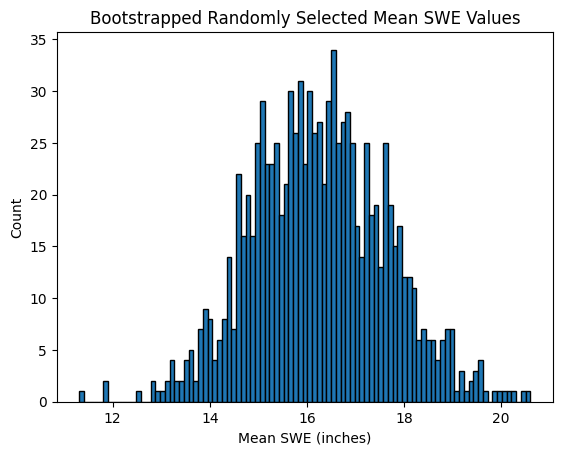

In [12]:
### Use matplotlib to plot a histogram of the bootstrapped means to compare to the conditioned SWE mean
binsize=0.1
min4hist=np.round(np.min(P_Bootstrap_mean),1)-binsize
max4hist=np.round(np.max(P_Bootstrap_mean),1)+binsize
nbins=int((max4hist-min4hist)/binsize)

plt.hist(P_Bootstrap_mean,nbins,edgecolor='black')
plt.xlabel('Mean SWE (inches)');
plt.ylabel('Count');
plt.title('Bootstrapped Randomly Selected Mean SWE Values');

In [13]:
## What is the probability that the snowfall was lower during El Nino by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nino,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nino)))*100 ##this is a one-sided test
print(f'Probability happened by chance, one-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.77
population_mean: 16.25
population_std: 1.38
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.37
Probability happened by chance, one-tailed test (percent): 35.0%


In [14]:
## What is the probability that the snowfall El Nino mean differs from the mean by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nino,2)}')

prob=(1-stats.norm.cdf(np.abs(z_nino)))*2*100 ##this is a two-sided test
print(f'Probability happened by chance, two-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.77
population_mean: 16.25
population_std: 1.38
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.37
Probability happened by chance, two-tailed test (percent): 71.0%


In [15]:
## What is the probability that the snowfall was higher during La Nina just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print(f'sample_mean - La Nina: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nina,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nina)))*100 ##this is a one-sided test
print(f'Probability happened by chance, one-tailed test (percent): {np.round(prob,0)}%')

sample_mean - La Nina: 16.71
population_mean: 16.25
population_std: 1.38
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.33
Probability happened by chance, one-tailed test (percent): 37.0%


In [16]:
## What is the probability that the snowfall during La Nina differed just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nina,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nina)))*2*100 ##this is a two-sided test
print(f'Probability happened by chance, two-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.71
population_mean: 16.25
population_std: 1.38
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.33
Probability happened by chance, two-tailed test (percent): 74.0%


#### Maybe you want to set up the bootstrap in another way?? 
Another bootstrapping approach is provided by Vineel Yettella (ATOC Ph.D. 2018).  
Check these out and see what you find!!

nan
nan


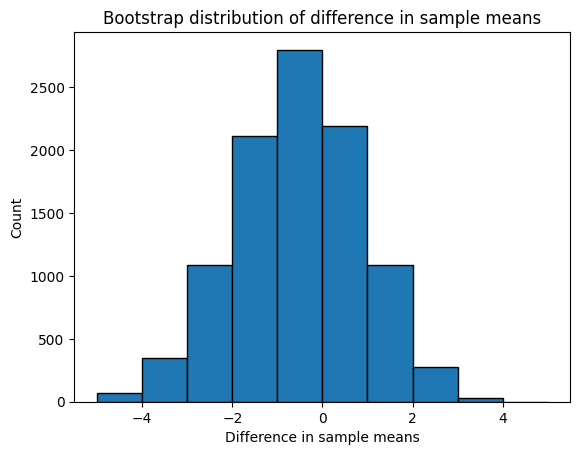

In [17]:
### Another bootstrapping strategy (provided by Vineel Yettella)
SWE = data['BerthoudPass_April1SWE_inches']
SWE_nino = data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches']

#We start by setting up a null hypothesis H0. 
#Our H0 will be that the difference in means of the two populations that the samples came from is equal to zero.
#We will use the bootstrap to test this null hypothesis.

#We next choose a significance level for the hypothesis test
alpha = 0.05

#All hypothesis tests need a test statistic.
#Here, we'll use the difference in sample means as the test statistic.
#create array to hold bootstrapped test statistic values
bootstrap_statistic = np.empty(10000)

#bootstrap 10000 times
for i in range(1,10000):
    
    #create a resample of SWE by sampling with replacement (same length as SWE)
    resample_original = np.random.choice(SWE, len(SWE), replace=True)
    
    #create a resample of SWE_nino by sampling with replacement (same length as SWE_nino)
    resample_nino = np.random.choice(SWE_nino, len(SWE_nino), replace=True)
    
    #Compute the test statistic from the resampled data, i.e., the difference in means
    bootstrap_statistic[i] = np.mean(resample_original) - np.mean(resample_nino)

#Let's plot the distribution of the test statistic
plt.hist(bootstrap_statistic,[-5,-4,-3,-2,-1,0,1,2,3,4,5],edgecolor='black')
plt.xlabel('Difference in sample means')
plt.ylabel('Count')
plt.title('Bootstrap distribution of difference in sample means')

#Create 95% CI from the bootstrapped distribution. The upper limit of the CI is defined as the 97.5% percentile
#and the lower limit as the 2.5% percentile of the boostrap distribution, so that 95% of the 
#distribution lies within the two limits

CI_up = np.percentile(bootstrap_statistic, 100*(1 - alpha/2.0))
CI_lo = np.percentile(bootstrap_statistic, 100*(alpha/2.0))

print(CI_up)
print(CI_lo)

#We see that the confidence interval contains zero, so we fail to reject the null hypothesis that the difference
#in means is equal to zero

### Question 3: Do you get the same result when you use a t-test?

Check your assumptions for the t-test and understand what is "under the hood" of your python coding.

In [18]:
## Apply a t-test to test the null hypothesis that the means of the two samples are the same 
## at the 95% confidence level.  Is this a one-sided or two-sided test??  Does it match what you got above??

## Calculate the t-statistic using the Barnes Notes - Compare a sample mean and a population mean.
## Barnes Eq. (96)
N=len(data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'])
print(f'N: {N}')
sample_mean=np.mean(data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'])
print(f'sample_mean: {np.round(sample_mean)}')
sample_std=np.std(data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'])
print(f'sample_std: {np.round(sample_std,2)}')
population_mean=np.mean(data['BerthoudPass_April1SWE_inches'])

## Using Barnes equation (96) to calculate probability using the t-statistic
t=(sample_mean-population_mean)/(sample_std/(np.sqrt(N-1)))
print(f'T-statistic: {np.round(t,2)}')
prob=(1-stats.t.cdf(t,N-1))*100
print(f'Probability (percent): {np.round(prob,0)}%')

N: 6
sample_mean: 17.0
sample_std: 3.34
T-statistic: 0.36
Probability (percent): 37.0%


In [19]:
## Calculate the t-statistic using the Barnes Notes - Compare two sample means.  Equation (110)
## See page 26 of Chapter 1 of the Barnes notes for a worked example.

sampledata1=data['BerthoudPass_April1SWE_inches']
sampledata2=data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches']

N1=len(sampledata1)
N2=len(sampledata2)
print(f'N1={N1}, N2={N2}')
sample_mean1=np.mean(sampledata1)
sample_mean2=np.mean(sampledata2)
print(sample_mean1)
print(sample_mean2)
sample_std1=np.std(sampledata1)
sample_std2=np.std(sampledata2)
print(sample_std1)
print(sample_std2)

print("T-statistic using Barnes Eq. 109/Eq. 110:")
s=np.sqrt((N1*sample_std1**2+N2*sample_std2**2)/(N1+N2-2))
print(f's: {np.round(s,2)}')
tw=(sample_mean1-sample_mean2-0)/(s*np.sqrt(1/N1+1/N2))
print(f'tw: {np.round(tw,2)}')
prob=(1-stats.t.cdf(tw,N-1))*100
print(f'Probability (percent): {np.round(prob,0)}%')

N1=87, N2=6
16.235632183908045
16.766666666666666
3.4135624365740673
3.335998934185814
T-statistic using Barnes Eq. 109/Eq. 110:
s: 3.45
tw: -0.37
Probability (percent): 64.0%


In [20]:
### Always try to code it yourself to understand what you are doing.
## Word to the wise - understand what is "under the hood" of your python function...
## Wait a second - What is that stats.ttest_ind function doing???  
# Check out the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# Review assumptions made with regard to the variances of the samples you are comparing...

print('Null Hypothesis: ENSO snow years have the same mean as the full record.')
t=stats.ttest_ind(data[data.Nino34_anomaly_prevDec>nino_th]['BerthoudPass_April1SWE_inches'],data['BerthoudPass_April1SWE_inches'],equal_var=False)
#Note: When equal_var is false (defaults to true), you assume the underlying population variances are NOT equal 
## and this function then uses Welch's T-test
print(f't: {np.round(t.statistic,2)}')
print(f'pvalue: {np.round(t.pvalue,2)}')

######## example using python function = improved after discussions with Yu-Wen in office hours :)
print('Try using a ttest function from python - using the p-value')
#stats.ttest_ind(gts_1850_norm,gts_mem1_norm)

print(t.pvalue)

if t.pvalue < 0.05:
    print('Can reject the null hypthesis.')
else:
    print('Cannot reject the null hypthesis.')   
    
#### can also compare tstatistic to tcrit to evaluate statistical significance.
N=len(data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'])
tcrit=stats.t.ppf(0.975,N-1)
print(f'tcrit: {np.round(tcrit,2)}')

if np.abs(t.statistic) > np.abs(tcrit):
    print('Can reject the null hypthesis.')
else:
    print('Cannot reject the null hypthesis.')     
    

Null Hypothesis: ENSO snow years have the same mean as the full record.
t: 0.35
pvalue: 0.74
Try using a ttest function from python - using the p-value
0.742209855769191
Cannot reject the null hypthesis.
tcrit: 2.13
Cannot reject the null hypthesis.


### SUMMARIZE WHAT YOU FOUND AND WHAT YOU LEARNED...  

Does ENSO affect total Colorado snow accumulation at Berthoud Pass, Colorado in the following winter? 

ENSO does not affect total Colorado snow accumulation at Berthoud Pass, CO in the following winter, regardless of whether you composite the ENSO data by index at 0.5, 1.0, or 1.5. We failed to reject the null hypothesis at a 95% significance level for any hypothesis test we tried, even trying bootstrapping.